# my super first notebook 

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import 

## def des variables 

In [2]:
N = 256 # number of synaptic input 
trials = 306 # number of trials 
K = 10 # number of classes 
seed = 1973

p_0 = 0.1 #average firing rate
p1 = .01 # average firing probability
B_theta = 0.51 # largeur des probas

h = 0.2 # hazard rate per trial

fig_width = 10
phi = np.sqrt(5)/2 + 1/2
figsize = (fig_width, fig_width/phi)

verb = True

## datas generation 

In [3]:
class data : 

    # ... Of Y 
    
    def vm(self, theta_0, B_theta) :
        p = torch.exp(torch.cos(torch.linspace(0, 2*torch.pi, N) - theta_0) / B_theta**2)
        p /= p.mean()
        p *= p_0
        return p 
    
    def stack(self):
        p = torch.zeros((N, K))
        for k in range(K) :
            theta_0 = 2 * torch.pi * (k + 1/2) / K
            p[:,k] = self.vm(theta_0 = theta_0, B_theta = B_theta)  
        return p
    
    def plot_proba(self, p, ms='-', alpha=.4):
        fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
        cmap = plt.get_cmap("plasma")
        if not p is None:
            for k in range(K):
                ax.step(torch.arange(N), p[:, k], ms, alpha=alpha, color=cmap(k/K))
        ax.set_ylabel('probability of firing for each address')
        ax.set_xlabel('input address')
        ax.set_xlim(0, N)
        return fig, ax

    # ... Of X
    def generative_model(self, p, T=None, do_poisson=False) :
        if T is None : 
            if do_poisson:
                # use a Poisson distribution to define variable lengths
                T = trials 
                b = torch.rand((T,N)) < p[None, :]
                b = torch.poisson(b)
                #T = torch.rand(trials)
                #T = torch.poisson(T)
                # doesn't work because torch.rand must be a tuple of ints, not Tensor, d'ailleurs en NP
            else:
                T = trials
                b = torch.rand((T,N)) < p[None, :] # on génère des b qui sont inférieurs à la probabilité. Si p ~ 0, b = 0, si p > 0, b > 0    
                b = b.long()
            return b
    
    def get_data(self, p) :
        b = self.generative_model(p.mean() * torch.ones(N)) # on appelle la fonction generative model, qui genère des b si p>0 --> donne des spikes un peu partout parce que p = p.means donc valeure moyenne dopnc 50/50 < à rand
        order = torch.arange(K)
        #torch.randperm(order)
        for k in order:
            b = torch.vstack((b, self.generative_model(p[:,k]))) # on prend b avec des spikes 50/50 et on rappelle generative_modele, donc il refait le truc de generation des b que si p>0, mais cette fois p varie across les neurones donc b ne sera plus aléatoire, il sera ok quand p>0 et 0 quand p~0. On fait ça pour chaque K et on obtient la super figure. Par contre, j'ai du mal à comprendre pourquoi on a besoin de le faire avec p_mean avant, j'ai vu que si on l'enlevait ça ne marchait plus mais idkwhy 
            #b = self.generative_model(p[:,k])
        return b
    
    def plot_raster(self, b, alpha=.4):
        fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width))
        cmap = plt.get_cmap("plasma")
        ax.pcolormesh(b.T)
        ax.set_xlabel('time (bin number)')
        ax.set_ylabel('input address')
        return fig, ax


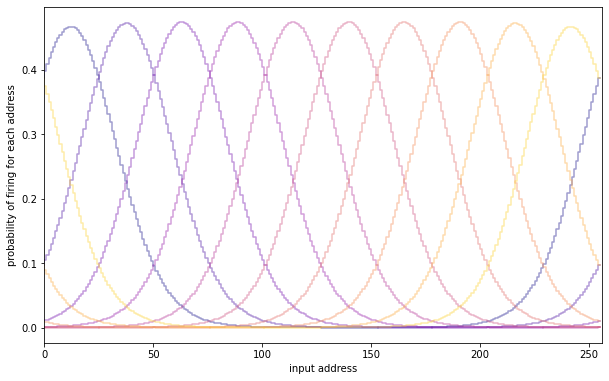

In [4]:
d = data()        
p_true = d.stack() 
d.plot_proba(p_true)

plt.show()

### visu

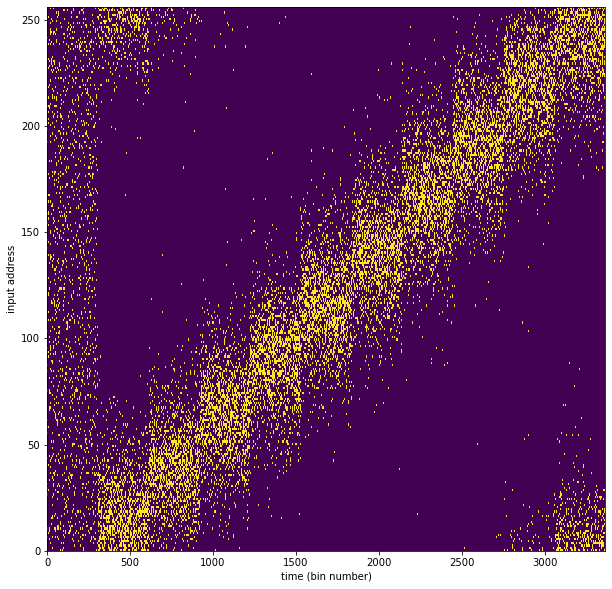

In [5]:
b = d.get_data(p_true)
d.plot_raster(b)
plt.show()

In [6]:
b.shape

torch.Size([3366, 256])

On vient de définir des fonctions pour __générer nos X et nos Y__.

Les X correspondent à __l'activité de 256 neurones à un temps T,__ au cours de différents trials. A chaque trial est présenté une orientation, entrainant une certaine activité neuronale. __Les Y correspondent à l'activité neuronale induite par la présentation d'une orientation.__ 

Pour générer les données, on commence par définir la __probabilité de firing de chaque neurone, pour chaque orientation (nos Y).__ A partir de ces probabilités, on génère __l'activité neuronale au cours de différents trials (nos X)__ de sorte à ce que, à chaque trial, l'activité neuronale feat avec les probabilités de firing des neurones déterminées en Y.

Le but de ce notebook sera de __tester différentes méthodes__ pour déterminer, __à partir de l'activité neuronale, l'orientation présentée.__ 

__1/ detection__ : sans apprentissage, en connaissant les proba de firing des neurones pour les différentes orientations, on peut décoder l'information en déterminant la surprise. 

__2/ apprentissage suppervisé__ : en connaissant les probas de firing des neurones pour chaque orientation, apprentissage de p_hat (initialisé aléatoirement) selon regression logistique


__3/ apprentissage non suppervisé__ : en ne connaissant pas les probas de firing, apprentissage de p_hat par k-means

## detection 

In [7]:
class OnlineBinaryDetection(data) :
        
    # la surprise est très importante, elle se base sur les probabilités de firing des neurones pour déterminer si l'occurence d'un spike est surprenante ou non.
    # b peut prendre deux valeurs : 0 ou 1 (spike ou pas spike), en le multipliant par la probabilité de firing, on quantifie la surprise d'occurence ou d'absence du spike
    # si b = 1 alors b*log2p + 1-b*log2 1-p = log2p
    # si b = 0 alors b*log2p + 1-b*log2 1-p = log2 1-p
    # si p de voir apparaitre un spike est forte alors log2p est faible, alors que log2 1-p est forte, la surprise est donc importante si b est différent de ce à quoi on s'attend 
    def surprise(self, b, p) :
        return -(b[:, :, None]*torch.log2(p[None, :, :]) + (1-b[:, :, None])*torch.log2(1-p[None, :, :])).sum(axis=1)
    
    def get_surprise(self, b, p) :
        T, N = b.shape
        N_, K = p.shape
        
        # a chaque trial on présente une orientation donc à chaque trial on devrait avoir peu de surprise pour un K mais plus de surprise pour les autres K  
        S = torch.zeros((T, K)) # pourquoi dim 2 = K ? 
        S[-1, :] = self.surprise(p_0 * torch.ones((1, N)), p) 
        
        for t in range(T) :
            S[t, :] = (1- h) * S[t-1, :] + h * self.surprise(b[t,:][None,:], p)
            #S[t, :] = self.surprise(b[t,:][None,:], p) # si on met cette ligne, les surprises sont bcp plus larges et se supperposent, need explanation about what is happened au dessus 
        return S
    
    def get_proba(self, S) :
        two = torch.Tensor([2])
        P = torch.exp(-torch.log(two) * S)
        P /= P.sum(axis = 1)[:, None]
        return P

    def plot_surprise(self, S,  xlabel='trials', ylabel='surprise',alpha=.4):
        fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
        cmap = plt.get_cmap("plasma")
        ax.plot(S, alpha=alpha)
        ax.set_xlabel('trials')
        ax.set_ylabel('surprise')
        return fig, ax
    
    def plot_proba(self, P, xlabel='trials', ylabel='proba',alpha=.4):
        fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
        ax.plot(P, alpha=alpha)
        ax.set_xlabel('trials')
        ax.set_ylabel('proba')
        return fig, ax
    
    

(<Figure size 720x444.984 with 1 Axes>,
 <AxesSubplot:xlabel='trials', ylabel='surprise'>)

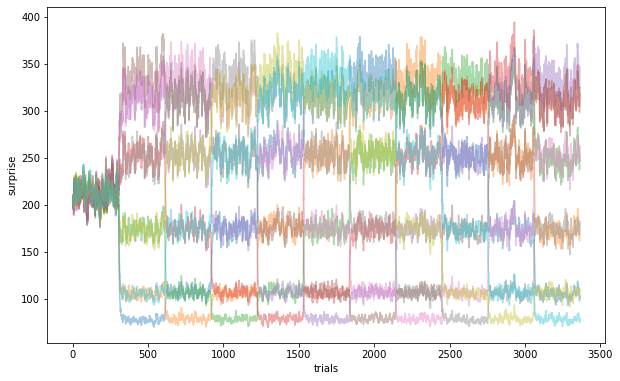

In [8]:
obd = OnlineBinaryDetection()
S = obd.get_surprise(b, p_true)
obd.plot_surprise(S)
# je voudrais que les couleurs correspondent aux probas générées 

On voit que pour certains trials, la surprise est super faible pour une classe, plus élevée pour d'autres. Surprise faible = activité X correspond ++ à proba de firing d'une classe


(<Figure size 720x444.984 with 1 Axes>,
 <AxesSubplot:xlabel='trials', ylabel='proba'>)

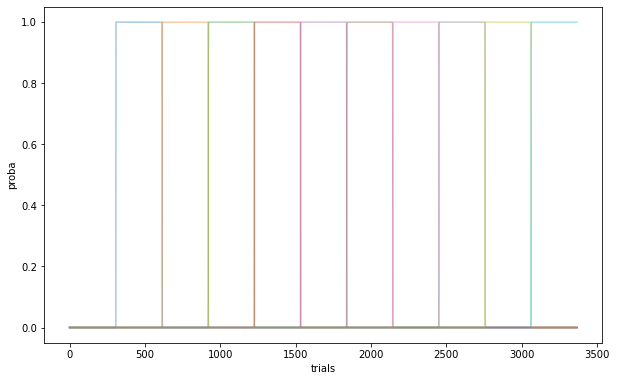

In [9]:
P = obd.get_proba(S)
P = torch.nan_to_num(P, nan=0.0, posinf=None, neginf=None, out=None)
obd.plot_proba(P)

On passe la surprise en proba grasse à une super formule de maths qu'il faut que je dissèque un peu et on obtient cette classification : là où la surprise est faible, il y a une forte probabilité pour que l'activité appartienne à la classe. Ca marche bien parce que pas de proba intermediaire (alors qu'il y avait des surprises intermediaires) ici on voit bien à quel point la detetction marche bien)

P = ground truth 

In [10]:
# faire un plot de P en fonction de N pour tous les K (1 trial par K) 


## supervised learning 

In [11]:
from torch.utils.data import TensorDataset, DataLoader
from torchvision import models
from torchsummary import summary

In [12]:
torch.set_default_tensor_type("torch.DoubleTensor")
criterion = torch.nn.BCELoss(reduction="mean")

_b = torch.Tensor.double(b)
P_ = torch.Tensor.double(P)

In [13]:
# définition du nn

class LogisticRegressionModel(torch.nn.Module):
    
    def __init__(self, N, K, bias=True): # (self, input_dim, output_dim)
        super(LogisticRegressionModel, self).__init__() 
        # couche 1
        self.linear = torch.nn.Linear(N, K, bias=bias) 
        # couche 2 
        self.nl = torch.nn.Sigmoid()

    def forward(self, x):
        return self.nl(self.linear(x))

In [14]:
logistic_model = LogisticRegressionModel(N, K) #(input_dim, output_dim)
outputs = logistic_model(_b)

In [15]:
learning_rate = 0.005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 9 + 1 # epoch = le nombre de passages dans l'ensemble des données d'entraînement que le réseau a effectués, ici 513 max
amsgrad = False # gives similar results
amsgrad = True  # gives similar results
batch_size = 100

In [16]:
# définition des fonctions pour apprentissage

def fit_data(_b, P_, learning_rate=learning_rate,
             batch_size=batch_size,
             num_epochs=num_epochs,
             betas=betas,
             verbose=True, 
             **kwargs):
    
    b_0 = _b[:, None] # nos entrées 
    labels = P_[:, None] # ground_true = proba d'appartenance à une classe déterminées pendant la détection 
    
    loader = DataLoader(TensorDataset(b_0, labels), 
                        batch_size=batch_size, 
                        shuffle=True)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    N_batch = b.shape[0] 
    N = b.shape[1]  
    n_classes = P.shape[1]

    logistic_model = LogisticRegressionModel(N, K)
    logistic_model = logistic_model.to(device)
    logistic_model.train()
    
    optimizer = torch.optim.Adam(logistic_model.parameters(), 
                                 lr=learning_rate, 
                                 betas=betas, 
                                 amsgrad=amsgrad) 
    
    for epoch in range(int(num_epochs)): 
        logistic_model.train()
        losses = [] 
        
        for b_, labels_ in loader: 
            b_, labels_ = b_.to(device), labels_.to(device)
            outputs = logistic_model(b_)  
            loss = criterion(outputs, labels_) # les probas de classification du nn doivent correspondre à celle obtenues pdt la détection 
                                               
            optimizer.zero_grad()
            loss.backward()
            optimizer.step() 
            
            losses.append(loss.item())   
            
        if verbose and (epoch % (num_epochs // 32) == 0):
            print(f"Iteration: {epoch} - Loss: {np.mean(losses):.5f}") 
    
    logistic_model.eval()
    b_0, labels = _b[:, None], P_[:, None]
    outputs = logistic_model(b_0)  
    loss = criterion(outputs, labels).item()
    return logistic_model, loss

In [17]:
logistic_model, loss = fit_data(_b, P_, verbose=True)

Iteration: 0 - Loss: 0.31401
Iteration: 16 - Loss: 0.03429
Iteration: 32 - Loss: 0.02549
Iteration: 48 - Loss: 0.02149
Iteration: 64 - Loss: 0.01905
Iteration: 80 - Loss: 0.01727
Iteration: 96 - Loss: 0.01591
Iteration: 112 - Loss: 0.01497
Iteration: 128 - Loss: 0.01409
Iteration: 144 - Loss: 0.01328
Iteration: 160 - Loss: 0.01272
Iteration: 176 - Loss: 0.01209
Iteration: 192 - Loss: 0.01156
Iteration: 208 - Loss: 0.01112
Iteration: 224 - Loss: 0.01072
Iteration: 240 - Loss: 0.01034
Iteration: 256 - Loss: 0.01009
Iteration: 272 - Loss: 0.00971
Iteration: 288 - Loss: 0.00948
Iteration: 304 - Loss: 0.00920
Iteration: 320 - Loss: 0.00891
Iteration: 336 - Loss: 0.00868
Iteration: 352 - Loss: 0.00849
Iteration: 368 - Loss: 0.00828
Iteration: 384 - Loss: 0.00810
Iteration: 400 - Loss: 0.00785
Iteration: 416 - Loss: 0.00774
Iteration: 432 - Loss: 0.00757
Iteration: 448 - Loss: 0.00738
Iteration: 464 - Loss: 0.00726
Iteration: 480 - Loss: 0.00710
Iteration: 496 - Loss: 0.00695
Iteration: 512 -

In [18]:
outputs = logistic_model(_b)
outputs = outputs.detach().numpy()

In [19]:
class coucou : 

    def plot_out(self, outputs, xlabel='trials', ylabel='proba',alpha=.4):
        fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
        ax.plot(outputs, alpha=alpha)
        ax.set_xlabel('trials')
        ax.set_ylabel('proba')
        return fig, ax

(<Figure size 720x444.984 with 1 Axes>,
 <AxesSubplot:xlabel='trials', ylabel='proba'>)

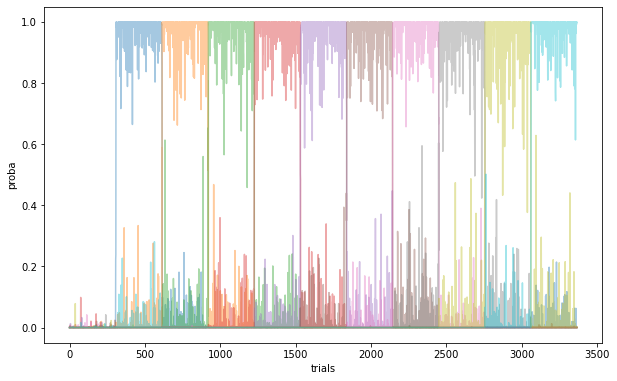

In [20]:
c = coucou()
c.plot_out(outputs)

In [21]:
outputs = logistic_model(_b)

In [22]:
from sklearn import metrics

p = torch.argmax(P,dim=1)
out = torch.argmax(outputs,dim=1)
cm = metrics.confusion_matrix(p, out)

In [23]:
def plot_confusion_matrix(cm, K,
                          normalize=False,
                          title='Confusion matrix',
                          cmap = plt.get_cmap("plasma")):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap, alpha =.4)
    plt.title(title)
    plt.colorbar()
    #tick_marks = np.arange((K))
    #plt.xticks((K, K))
    #plt.yticks(K, K)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    #for i, j in (range(K)):
     #   plt.text(j, i, format(cm[i, j], fmt),
      #           horizontalalignment="center",
       #          color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[329  23  27  45  33  43  36  18  29  32]
 [  0 305   1   0   0   0   0   0   0   0]
 [  0   0 304   1   0   0   0   0   0   0]
 [  0   0   0 305   2   0   0   0   0   0]
 [  0   0   0   0 306   0   0   0   0   0]
 [  0   0   0   0   0 304   1   0   0   0]
 [  0   0   0   0   0   0 306   1   0   0]
 [  0   0   0   0   0   0   0 305   1   0]
 [  0   0   0   0   0   0   0   0 304   0]
 [  0   0   0   0   0   0   0   0   0 305]]


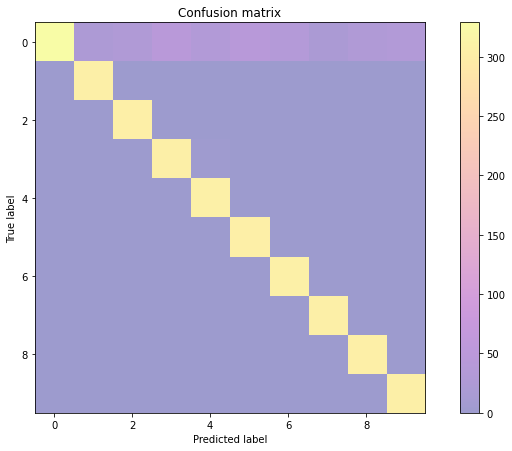

In [24]:
plt.figure(figsize=figsize)
plot_confusion_matrix(cm,K)

In [25]:
print('Accuracy :', metrics.accuracy_score(p, out))

Accuracy : 0.9129530600118836


## self-supervised learning 


L'idée est de maintenant entrainer le réseau sans connaître le ground_true. A la place, on va prendre l'output du logisitc model comme label...

In [26]:
with torch.no_grad():
    outputs_0 = logistic_model(_b)
    labels = outputs_0.argmin(dim=1)
    
    
#labels = torch.Tensor.double(labels)
#labels.shape, outputs_0.shape

In [42]:
def decod_data(_b, outputs_0, learning_rate=learning_rate,
             batch_size=batch_size,
             num_epochs=num_epochs,
             betas=betas,
             verbose=True, 
             **kwargs):
        
    b_0 = _b[:, None] # nos entrées 
    labels_0 = outputs_0[:, None] # ground_true = proba d'appartenance à une classe déterminées pendant la détection 
    
    loader = DataLoader(TensorDataset(b_0, labels_0), 
                        batch_size=batch_size, 
                        shuffle=True)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    N_batch = b.shape[0] 
    N = b.shape[1]  
    n_classes = P.shape[1]

    logistic_model = LogisticRegressionModel(N, K)
    logistic_model = logistic_model.to(device)
    logistic_model.train()
    
    optimizer = torch.optim.Adam(logistic_model.parameters(), 
                                 lr=learning_rate, 
                                 betas=betas, 
                                 amsgrad=amsgrad) 
    
    for epoch in range(int(num_epochs)): 
        logistic_model.train()
        losses = [] 
        
        for b_, labels_ in loader: 
            b_, labels_ = b_.to(device), labels_.to(device)
            outputs = logistic_model(b_)  
            loss = criterion(outputs, labels_) # les probas de classification du nn doivent correspondre à celle obtenues pdt la détection 
                                               
            optimizer.zero_grad()
            loss.backward()
            optimizer.step() 
            
            losses.append(loss.item())   
            
        if verbose and (epoch % (num_epochs // 32) == 0):
            print(f"Iteration: {epoch} - Loss: {np.mean(losses):.5f}") 
    
    logistic_model.eval()
    b_0, labels_0 = _b[:, None], outputs_0[:, None]
    _outputs = logistic_model(b_0)  
    loss = criterion(_outputs, labels_0).item()
    return logistic_model, loss


In [44]:
logistic_model_0, loss_0 = decod_data(_b, outputs_0, verbose=True)

Iteration: 0 - Loss: 0.31791
Iteration: 16 - Loss: 0.03600
Iteration: 32 - Loss: 0.02818
Iteration: 48 - Loss: 0.02484
Iteration: 64 - Loss: 0.02303
Iteration: 80 - Loss: 0.02171
Iteration: 96 - Loss: 0.02090
Iteration: 112 - Loss: 0.02024
Iteration: 128 - Loss: 0.01970
Iteration: 144 - Loss: 0.01926
Iteration: 160 - Loss: 0.01890
Iteration: 176 - Loss: 0.01864
Iteration: 192 - Loss: 0.01842
Iteration: 208 - Loss: 0.01820
Iteration: 224 - Loss: 0.01802
Iteration: 240 - Loss: 0.01782
Iteration: 256 - Loss: 0.01768
Iteration: 272 - Loss: 0.01754
Iteration: 288 - Loss: 0.01740
Iteration: 304 - Loss: 0.01735
Iteration: 320 - Loss: 0.01721
Iteration: 336 - Loss: 0.01716
Iteration: 352 - Loss: 0.01714
Iteration: 368 - Loss: 0.01701
Iteration: 384 - Loss: 0.01698
Iteration: 400 - Loss: 0.01690
Iteration: 416 - Loss: 0.01691
Iteration: 432 - Loss: 0.01678
Iteration: 448 - Loss: 0.01674
Iteration: 464 - Loss: 0.01669
Iteration: 480 - Loss: 0.01675
Iteration: 496 - Loss: 0.01665
Iteration: 512 -

In [45]:
outputss = logistic_model_0(_b)
outputss = outputss.detach().numpy()

(<Figure size 720x444.984 with 1 Axes>,
 <AxesSubplot:xlabel='trials', ylabel='proba'>)

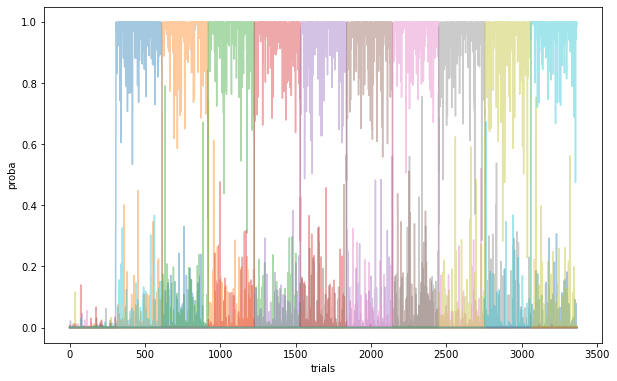

In [46]:
c = coucou()
c.plot_out(outputss)

le décoding est efficace 

In [47]:
outputss = logistic_model_0(_b)
outt = torch.argmax(outputss,dim=1)
cm2 = metrics.confusion_matrix(p, outt)

In [48]:
def plot_confusion_matrix(cm2, K,
                          normalize=False,
                          title='Confusion matrix',
                          cmap = plt.get_cmap("plasma")):
    
    if normalize:
        cm2 = cm2.astype('float') / cm2.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm2)
    
    plt.imshow(cm2, interpolation='nearest', cmap=cmap, alpha =.4)
    plt.title(title)
    plt.colorbar()
    #tick_marks = np.arange((K))
    #plt.xticks((K, K))
    #plt.yticks(K, K)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    #for i, j in (range(K)):
     #   plt.text(j, i, format(cm[i, j], fmt),
      #           horizontalalignment="center",
       #          color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[328  22  26  39  34  42  41  19  34  30]
 [  0 304   2   0   0   0   0   0   0   0]
 [  0   0 304   1   0   0   0   0   0   0]
 [  0   0   0 305   2   0   0   0   0   0]
 [  0   0   0   0 305   1   0   0   0   0]
 [  0   0   0   0   0 304   1   0   0   0]
 [  0   0   0   0   0   0 306   1   0   0]
 [  0   0   0   0   0   0   0 305   1   0]
 [  0   0   0   0   0   0   0   0 303   1]
 [  0   0   0   0   0   0   0   0   0 305]]


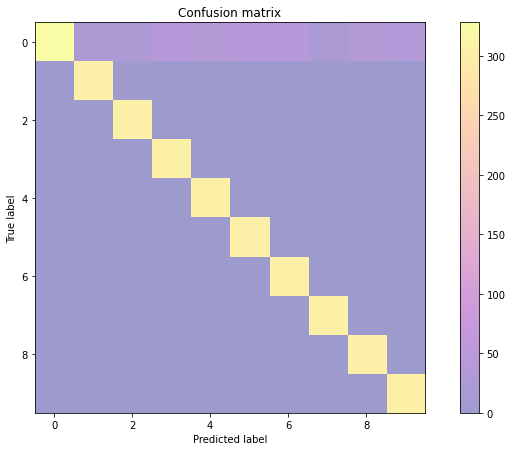

In [49]:
plt.figure(figsize=figsize)
plot_confusion_matrix(cm2,K)

In [50]:
print('Accuracy :', metrics.accuracy_score(p, outt))

Accuracy : 0.9117647058823529


### tentative de k means 

In [35]:
from kmeans_pytorch import kmeans
from tqdm import trange

In [36]:
N_epoch = 2**12

In [37]:
cluster_ids_b, cluster_centers = kmeans(X=b, num_clusters=K, distance='euclidean')

running k-means on cpu..


[running kmeans]: 8it [00:00, 14.95it/s, center_shift=0.000000, iteration=8, tol=0.000100] 


In [38]:
kmeans?

Signature:
kmeans(
    X,
    num_clusters,
    distance='euclidean',
    tol=0.0001,
    device=device(type='cpu'),
)
Docstring:
perform kmeans
:param X: (torch.tensor) matrix
:param num_clusters: (int) number of clusters
:param distance: (str) distance [options: 'euclidean', 'cosine'] [default: 'euclidean']
:param tol: (float) threshold [default: 0.0001]
:param device: (torch.device) device [default: cpu]
:return: (torch.tensor, torch.tensor) cluster ids, cluster centers
File:      c:\users\camil\anaconda3\lib\site-packages\kmeans_pytorch\__init__.py
Type:      function


In [39]:
cluster_centers.shape

torch.Size([10, 256])

Text(0, 0.5, '')

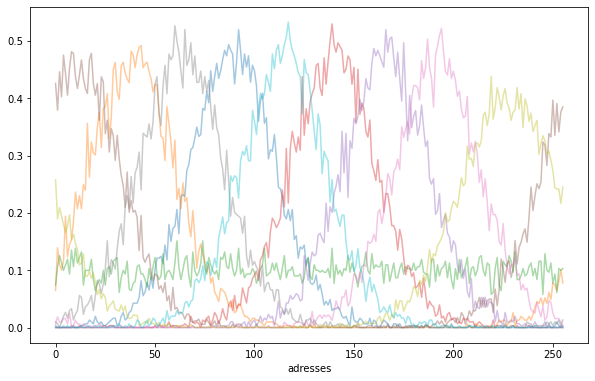

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot(cluster_centers.T, alpha = .4)
ax.set_xlabel('adresses')
ax.set_ylabel('')

In [62]:
def trying_to_do_des_choses(_b, lab, learning_rate=learning_rate,
             batch_size=batch_size,
             num_epochs=num_epochs,
             betas=betas,
             verbose=True, 
             **kwargs):
        
    b_0 = _b[:, None] # nos entrées 
    labels_1 = cluster_ids_b[:, None] # ground_true = proba d'appartenance à une classe déterminées pendant la détection 
    
    loader = DataLoader(TensorDataset(b_0, labels_1), 
                        batch_size=batch_size, 
                        shuffle=True)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    N_batch = b.shape[0] 
    N = b.shape[1]  
    n_classes = P.shape[1]

    logistic_model = LogisticRegressionModel(N, K)
    logistic_model = logistic_model.to(device)
    logistic_model.train()
    
    optimizer = torch.optim.Adam(logistic_model.parameters(), 
                                 lr=learning_rate, 
                                 betas=betas, 
                                 amsgrad=amsgrad) 
    
    for epoch in range(int(num_epochs)): 
        logistic_model.train()
        losses = [] 
        
        for b_, labels_ in loader: 
            b_, labels_ = b_.to(device), labels_.to(device)
            outputs = logistic_model(b_)  
            loss = criterion(outputs, labels_) # les probas de classification du nn doivent correspondre à celle obtenues pdt la détection 
                                               
            optimizer.zero_grad()
            loss.backward()
            optimizer.step() 
            
            losses.append(loss.item())   
            
        if verbose and (epoch % (num_epochs // 32) == 0):
            print(f"Iteration: {epoch} - Loss: {np.mean(losses):.5f}") 
    
    logistic_model.eval()
    b_0, labels_1 = _b[:, None], cluster_ids_b[:, None]
    _outputs = logistic_model(b_0)  
    loss = criterion(_outputs, labels_1).item()
    return logistic_model, loss


In [63]:
_b.shape, cluster_centers.shape, labels.shape, cluster_ids_b.shape

(torch.Size([3366, 256]),
 torch.Size([10, 256]),
 torch.Size([3366]),
 torch.Size([3366]))

In [69]:
 print(cluster_ids_b)

tensor([2, 2, 2,  ..., 8, 8, 8])


In [65]:
logistic_model_1, loss_1 = trying_to_do_des_choses(_b, cluster_ids_b, verbose=True)

ValueError: Using a target size (torch.Size([100, 1])) that is different to the input size (torch.Size([100, 1, 10])) is deprecated. Please ensure they have the same size.

In [ ]:
outputss = logistic_model_0(_b)
outputss = outputss.detach().numpy()